In [1]:
%run ../_config/config.py # Import the configuration settings
import logging

import cmdstanpy
from cmdstanpy import CmdStanModel

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)
import seaborn as sns
import scipy.stats as stats

In [2]:
df = pd.read_csv('../data/Howell_18.csv')
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [3]:
len(df["height"])

352

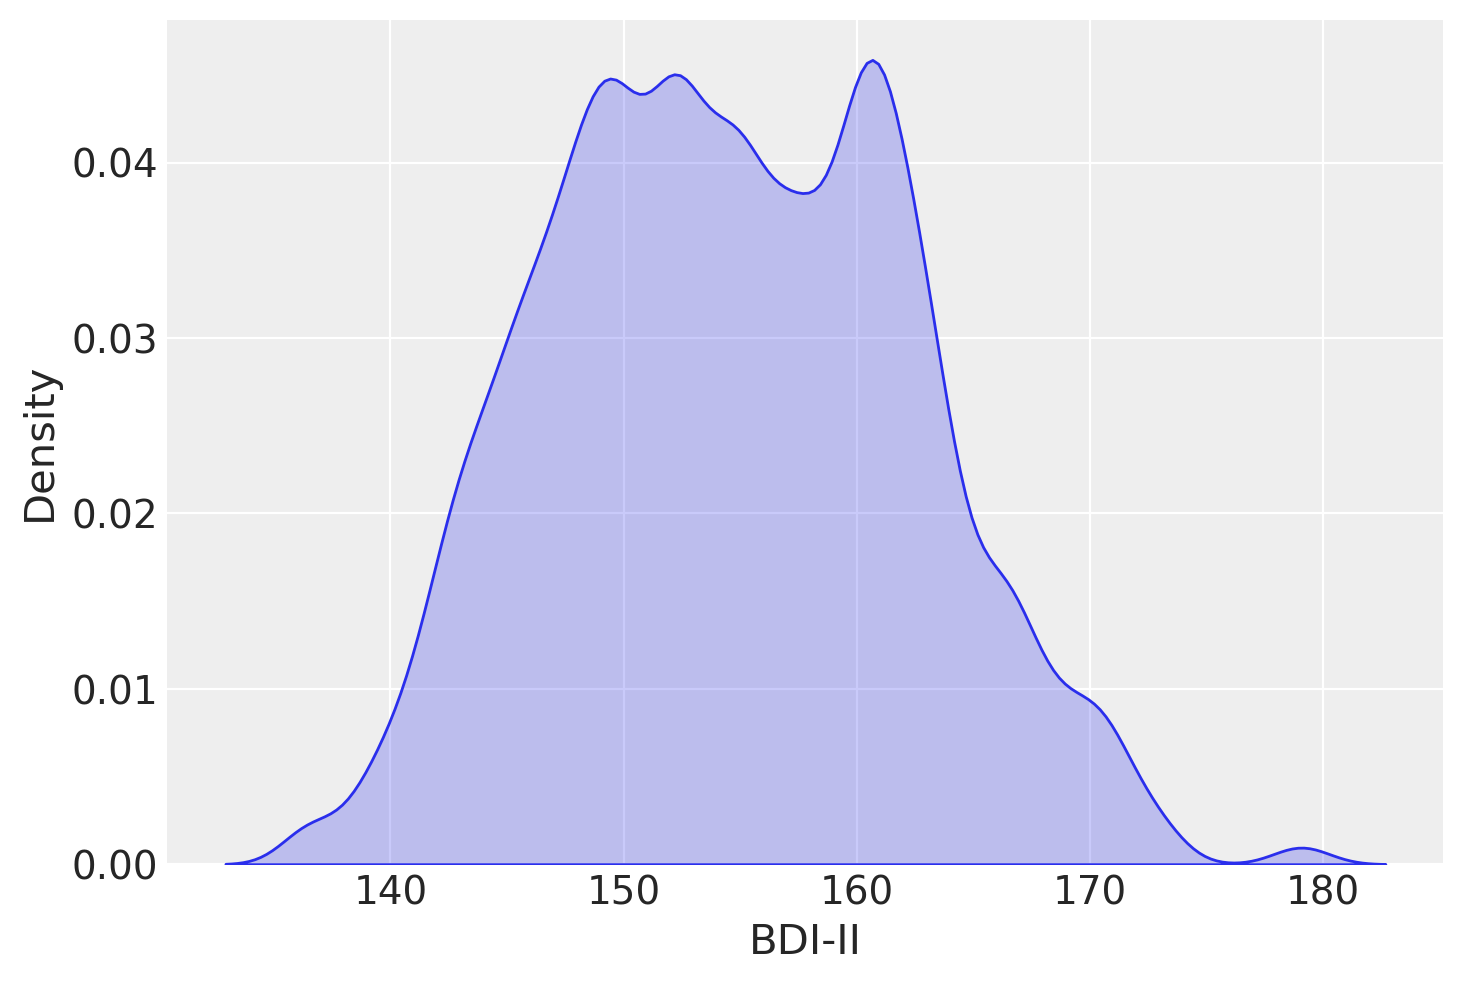

In [4]:
sns.kdeplot(df["height"], bw_adjust=0.5, fill=True)  # Adjust bw_adjust for smoothing
plt.xlabel("BDI-II")
plt.ylabel("Density")
plt.show()

In [5]:
np.mean(df["height"])

154.5970926136364

In [6]:
np.std(df["height"], ddof=1)

7.742332137351995

In [7]:
stan_file = os.path.join(project_directory, 'stan', 'gaussian_height.stan')
model = CmdStanModel(stan_file=stan_file)

In [8]:
print(model.code())

data {
    int<lower=1> N;
    vector[N] y;
}
parameters {
    real mu;
    real<lower=0> sigma;
}
model {
  y ~ normal(mu, sigma);
  sigma ~ normal(0, 20);
  mu ~ normal(181, 30);
}



In [9]:
stan_data = {'N': len(df["height"]), 'y': df["height"]}
print(stan_data)

{'N': 352, 'y': 0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
347    162.560
348    142.875
349    162.560
350    156.210
351    158.750
Name: height, Length: 352, dtype: float64}


In [10]:
trace = model.sample(
    data=stan_data,
    iter_warmup=1000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

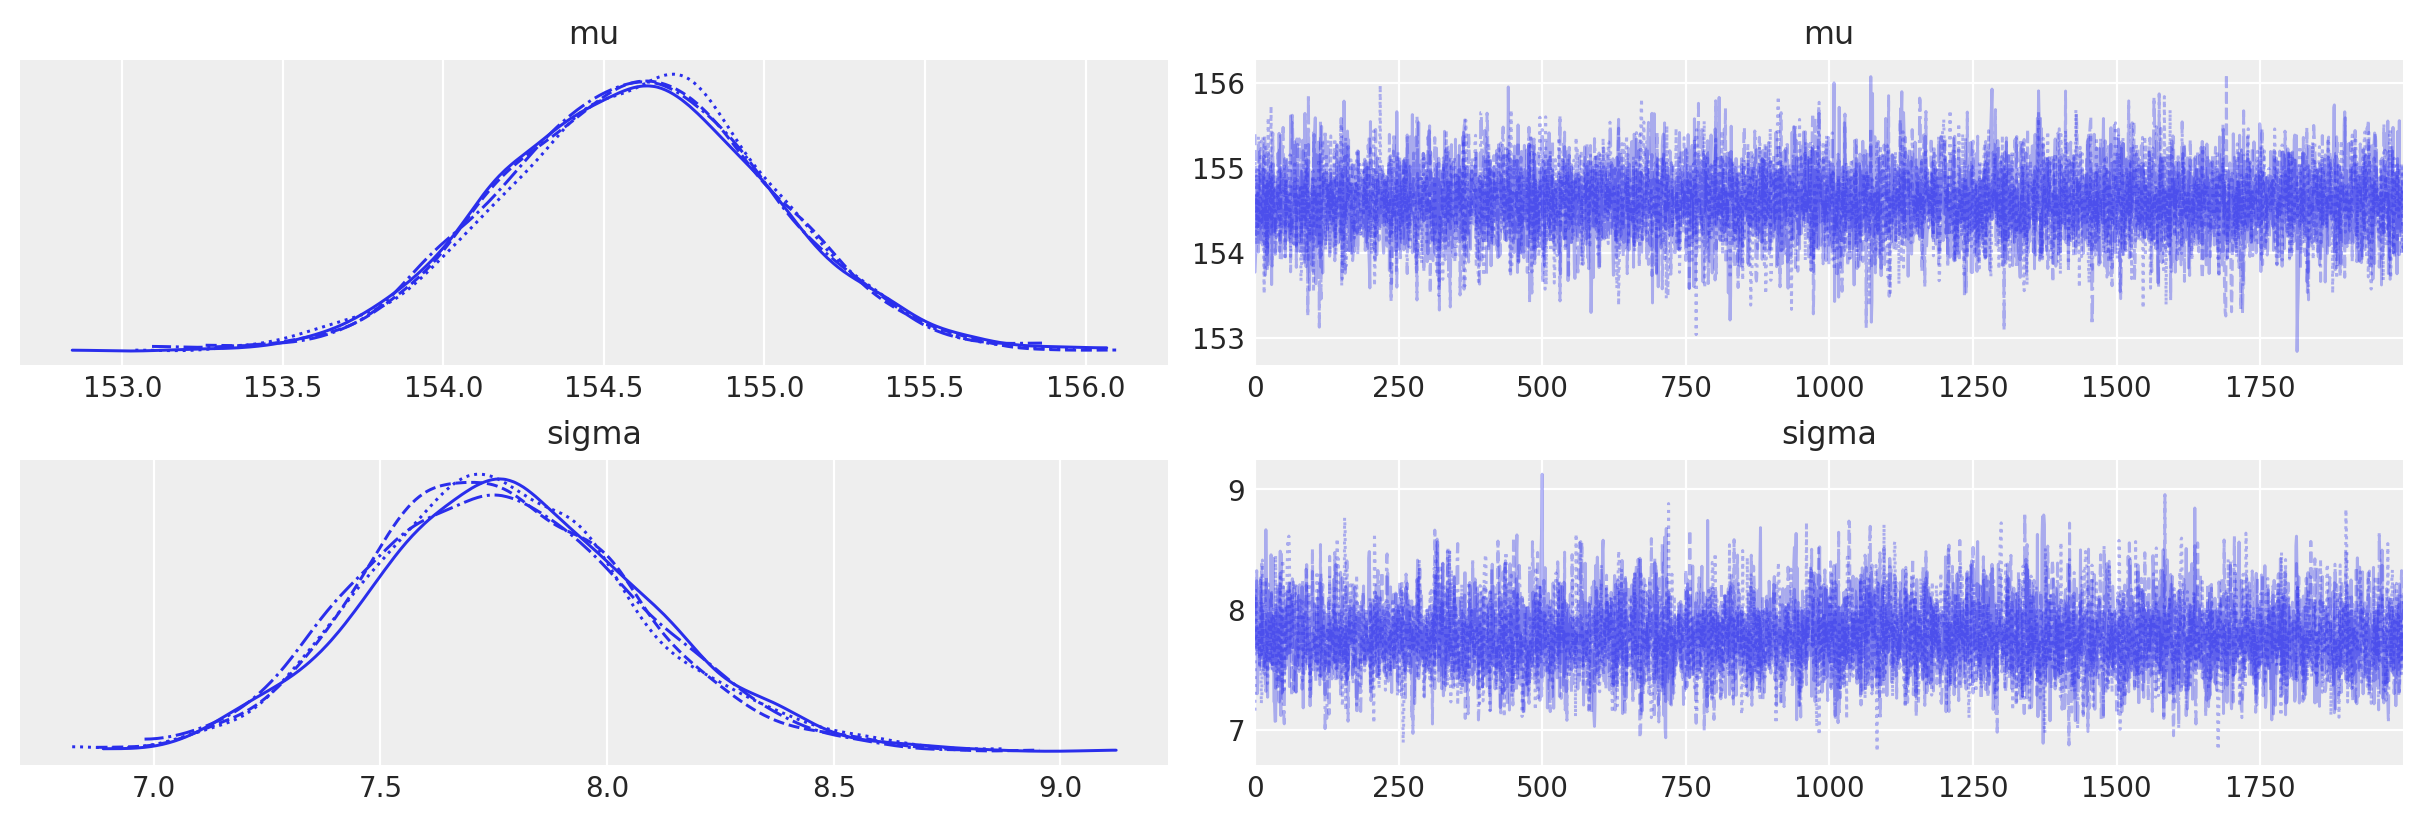

In [11]:
_ = az.plot_trace(trace)

In [12]:
az.summary(trace, hdi_prob=0.94, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.60,0.42,153.84,155.39,0.0,0.0,7864.52,5825.33,1.0
sigma,7.77,0.30,7.21,8.34,0.0,0.0,6655.48,5167.04,1.0


In [13]:
stan_ncp_file = os.path.join(project_directory, 'stan', 'gaussian_ncp.stan')
model_ncp = CmdStanModel(stan_file=stan_ncp_file)

In [14]:
print(model_ncp.code())

data {
    int<lower=1> N;
    vector[N] y;
}
transformed data {
    real y_mean = mean(y);
    real y_sd = sd(y);
}
parameters {
    real mu_raw;
    real<lower=0> sigma_raw;
}
transformed parameters {
    real mu;
    real<lower=0> sigma;
    mu = y_mean + y_sd * mu_raw;
    sigma = y_sd * sigma_raw;
}
model {
    // Priors:
    mu_raw ~ normal(0, 1);
    sigma_raw ~ normal(0, 1);
    // Likelihood:
    y ~ normal(mu, sigma);
}
generated quantities {
    vector[N] y_rep;
    for (n in 1:N) {
        y_rep[n] = normal_rng(mu, sigma);
    }
}



In [15]:
trace_ncp = model_ncp.sample(
    data=stan_data,
    iter_warmup=1000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

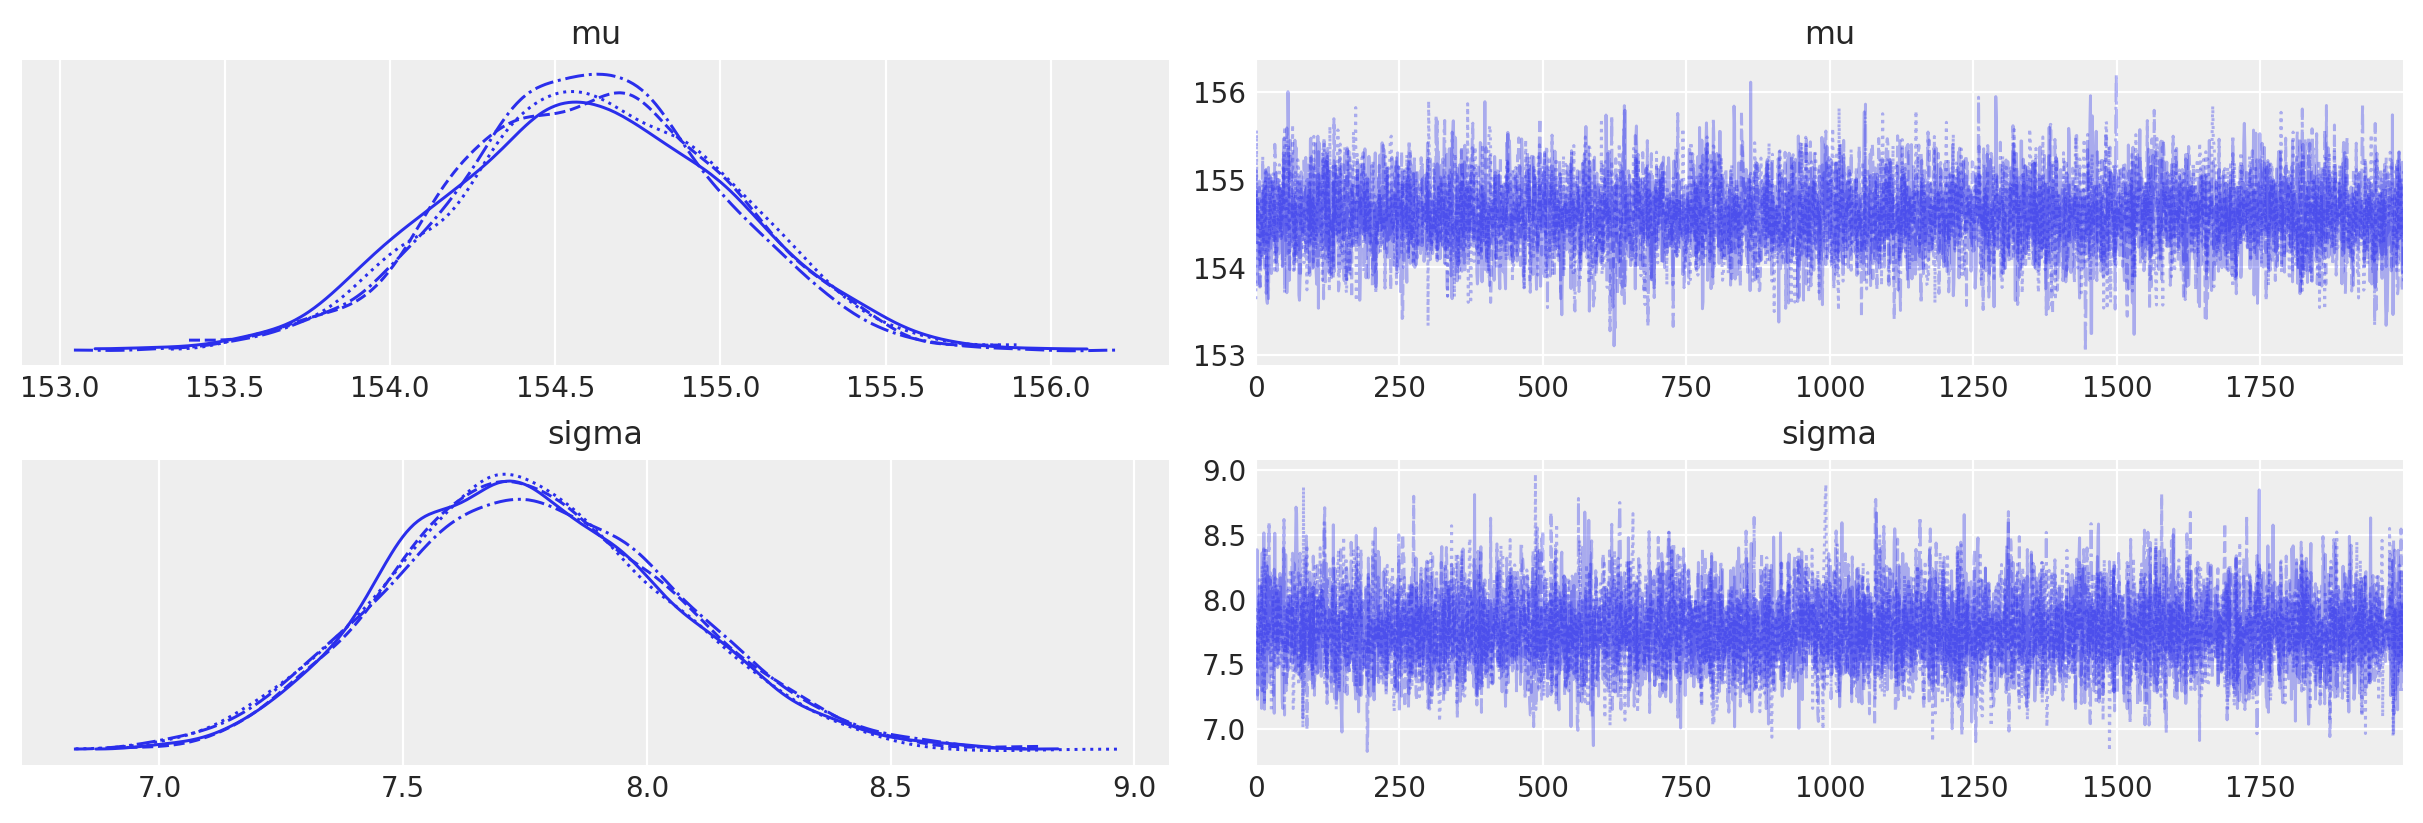

In [16]:
_ = az.plot_trace(trace_ncp, var_names=['mu', 'sigma'])

In [17]:
summary = az.summary(trace_ncp, var_names=['mu', 'sigma'], round_to=2)
print(summary)

         mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     154.61  0.42  153.83   155.39       0.01      0.0   6329.64   5029.29   
sigma    7.76  0.29    7.20     8.30       0.00      0.0   7836.78   5829.76   

       r_hat  
mu       1.0  
sigma    1.0  


In [18]:
# Convert to ArviZ InferenceData object
idata = az.from_cmdstanpy(
    posterior=trace_ncp,
    posterior_predictive='y_rep',
    observed_data={"y": df["height"]}
)

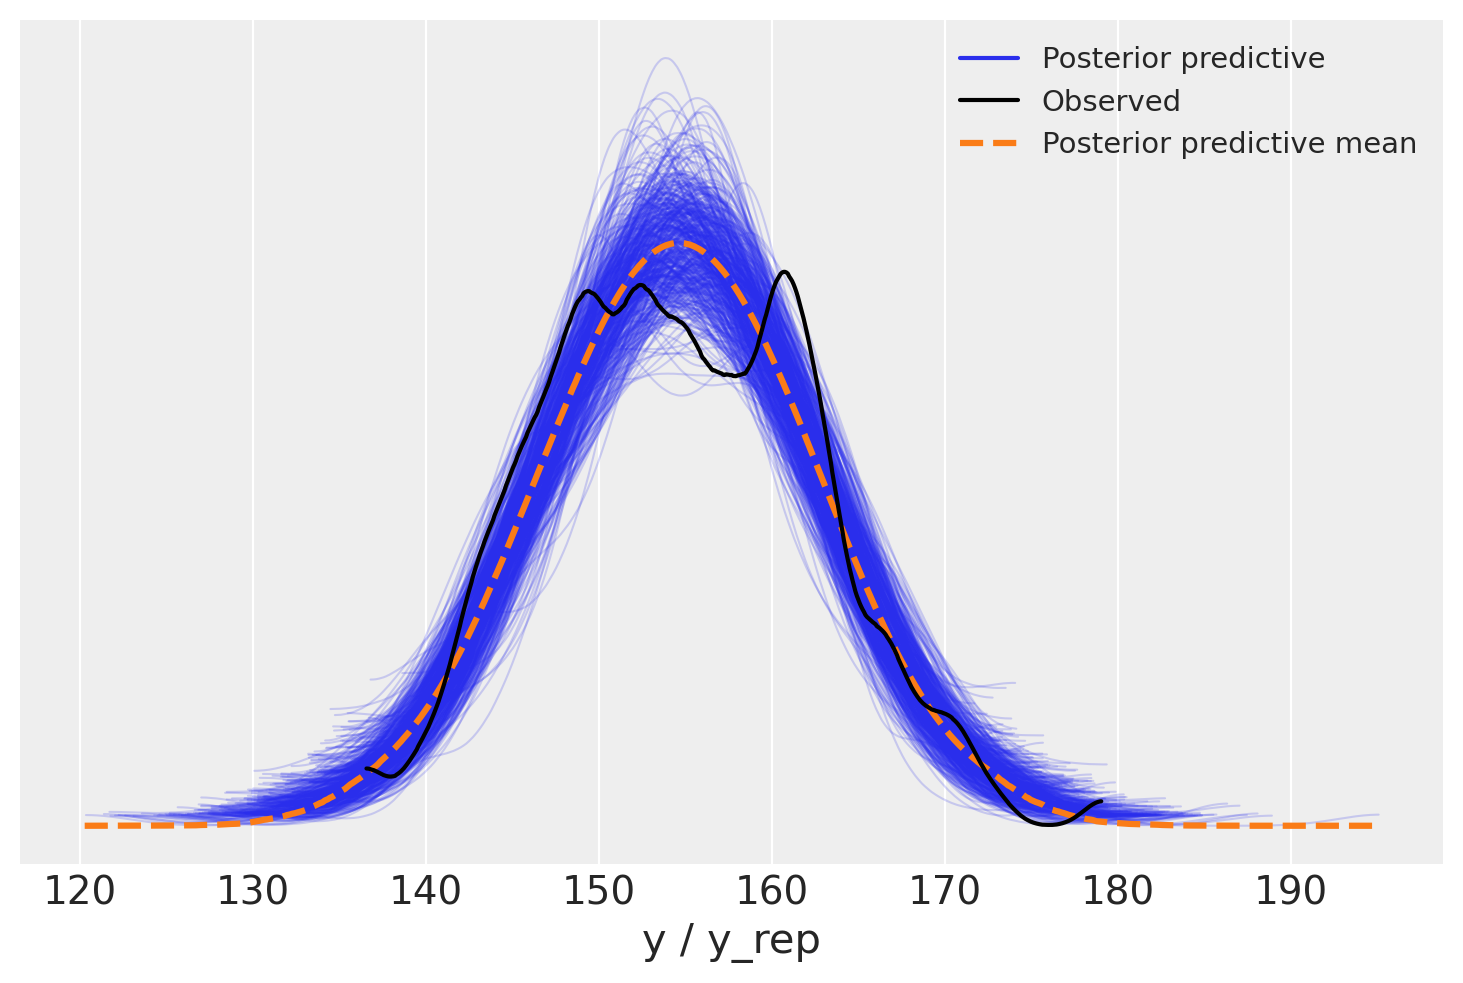

In [19]:
# Plot the posterior predictive check
_ = az.plot_ppc(idata, data_pairs={"y": "y_rep"}, num_pp_samples=500)

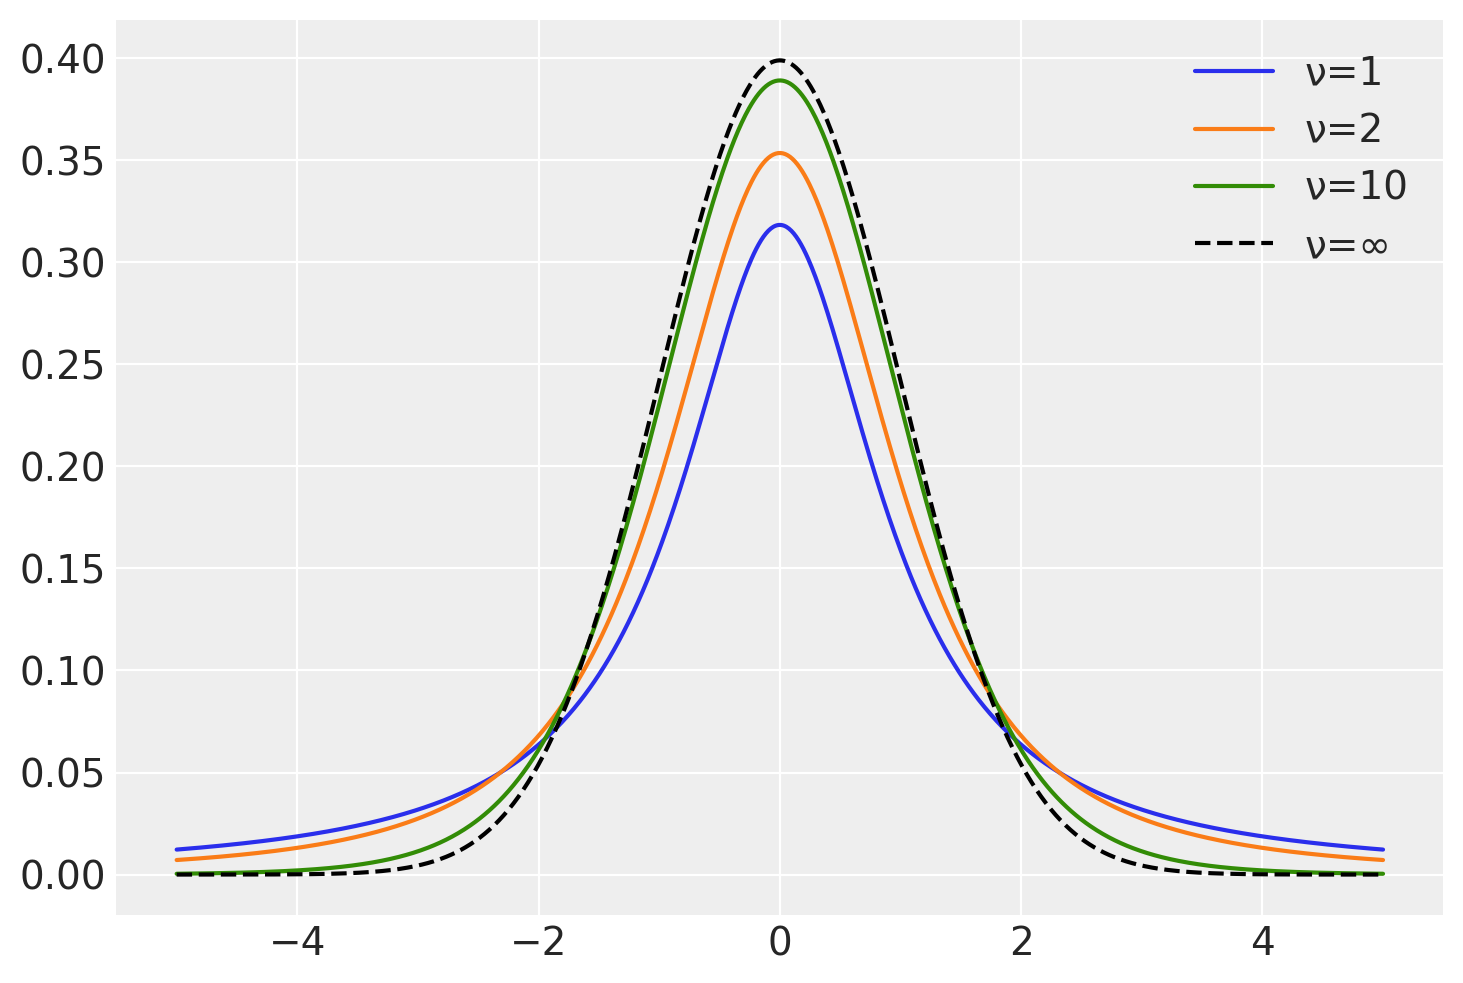

In [20]:
nu_values = [1, 2, 10]

fig, ax = plt.subplots()

for nu in nu_values:
    x = np.linspace(-5, 5, 1000)
    y = stats.t.pdf(x, df=nu, loc=0, scale=1)
    ax.plot(x, y, label=f"ν={nu}")

x = np.linspace(-5, 5, 1000)
y = stats.t.pdf(x, df=np.inf, loc=0, scale=1)
ax.plot(x, y, linestyle="--", color="k", label="ν=∞")

plt.legend()
plt.show()

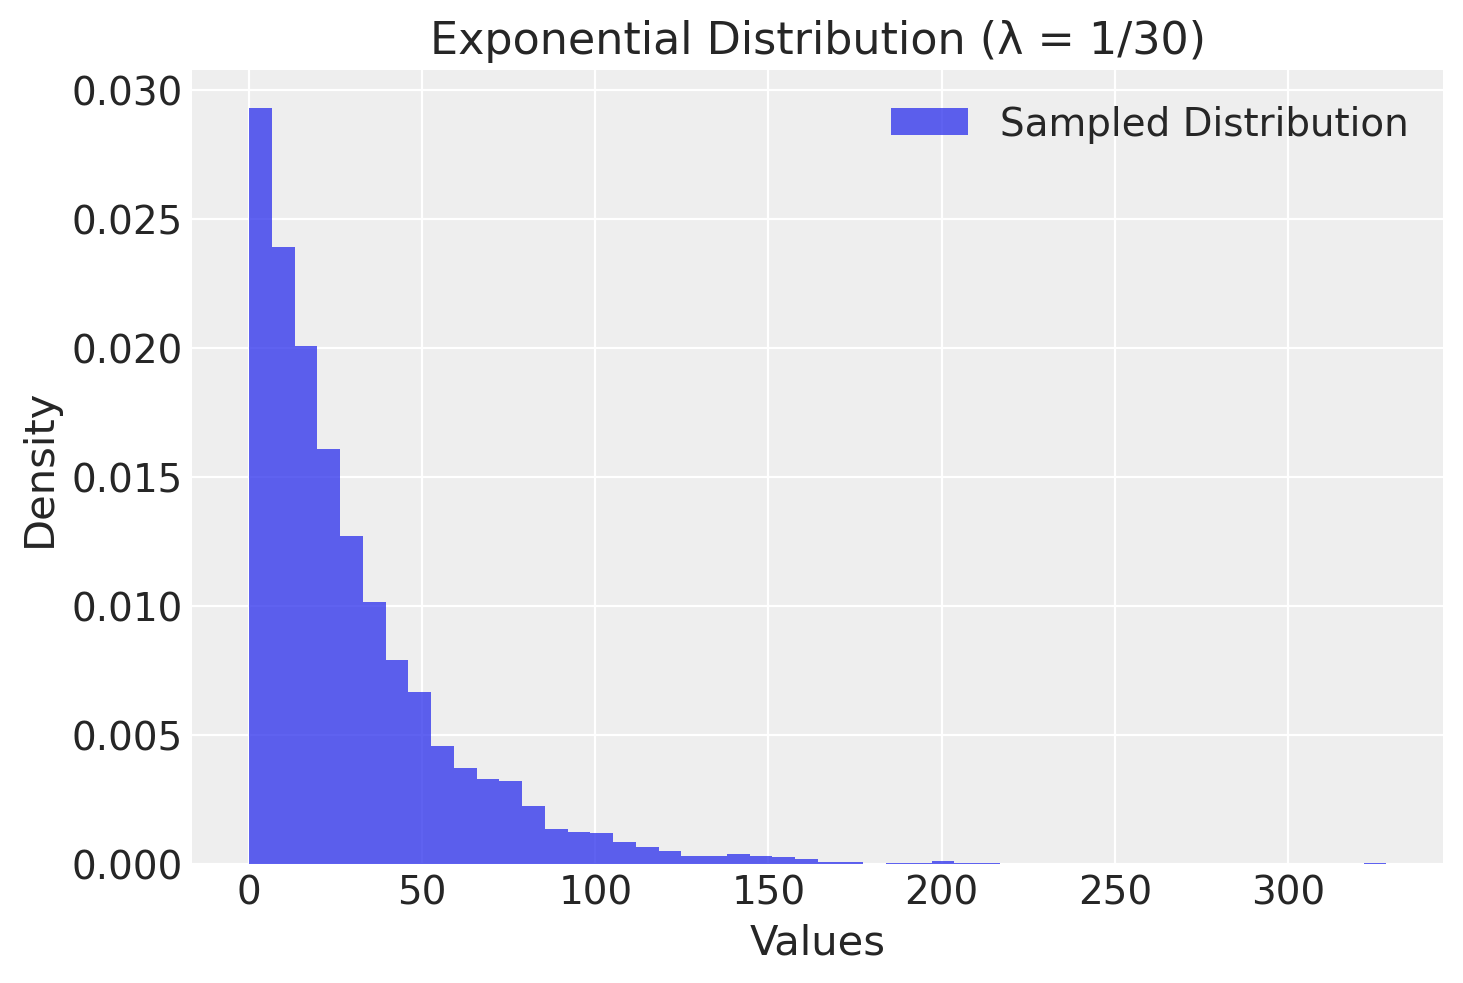

In [21]:
# Define the rate parameter for the exponential distribution
rate = 1 / 30

# Generate samples from the exponential distribution
samples = np.random.exponential(scale=1 / rate, size=10000)

# Create the histogram plot of the samples
plt.hist(samples, bins=50, density=True, alpha=0.75, label="Sampled Distribution")
plt.title("Exponential Distribution (λ = 1/30)")
plt.xlabel("Values")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
stan_student_file = os.path.join(project_directory, 'stan', 'student-model.stan')
model_student = CmdStanModel(stan_file=stan_student_file)

In [23]:
print(model_student.code())

data {
    int<lower=1> N;  // Numero totale di prove
    vector[N] y;  // Punteggio in ciascuna prova
}
transformed data {
    real y_mean = mean(y);  // Media dei dati osservati
    real y_sd = sd(y);  // Deviazione standard dei dati osservati
}
parameters {
    real mu_raw;  // Parametro latente standardizzato per mu
    real<lower=0> sigma_raw;  // Parametro latente standardizzato per sigma
    real<lower=1> nu;  // Gradi di libertà per la distribuzione t di Student
}
transformed parameters {
    real mu;  // Media sulla scala originale
    real<lower=0> sigma;  // Deviazione standard sulla scala originale
    mu = y_mean + y_sd * mu_raw;
    sigma = y_sd * sigma_raw;
}
model {
    // Distribuzioni a priori non centrate
    mu_raw ~ normal(0, 1);
    sigma_raw ~ normal(0, 1);
    nu ~ exponential(1.0 / 30.0);  // Prior esponenziale per i gradi di libertà
    // Verosimiglianza
    y ~ student_t(nu, mu, sigma);
}
generated quantities {
    vector[N] y_rep;
    for (n in 1:N) {
     

In [24]:
trace_student = model_student.sample(
    data=stan_data,
    iter_warmup=1000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

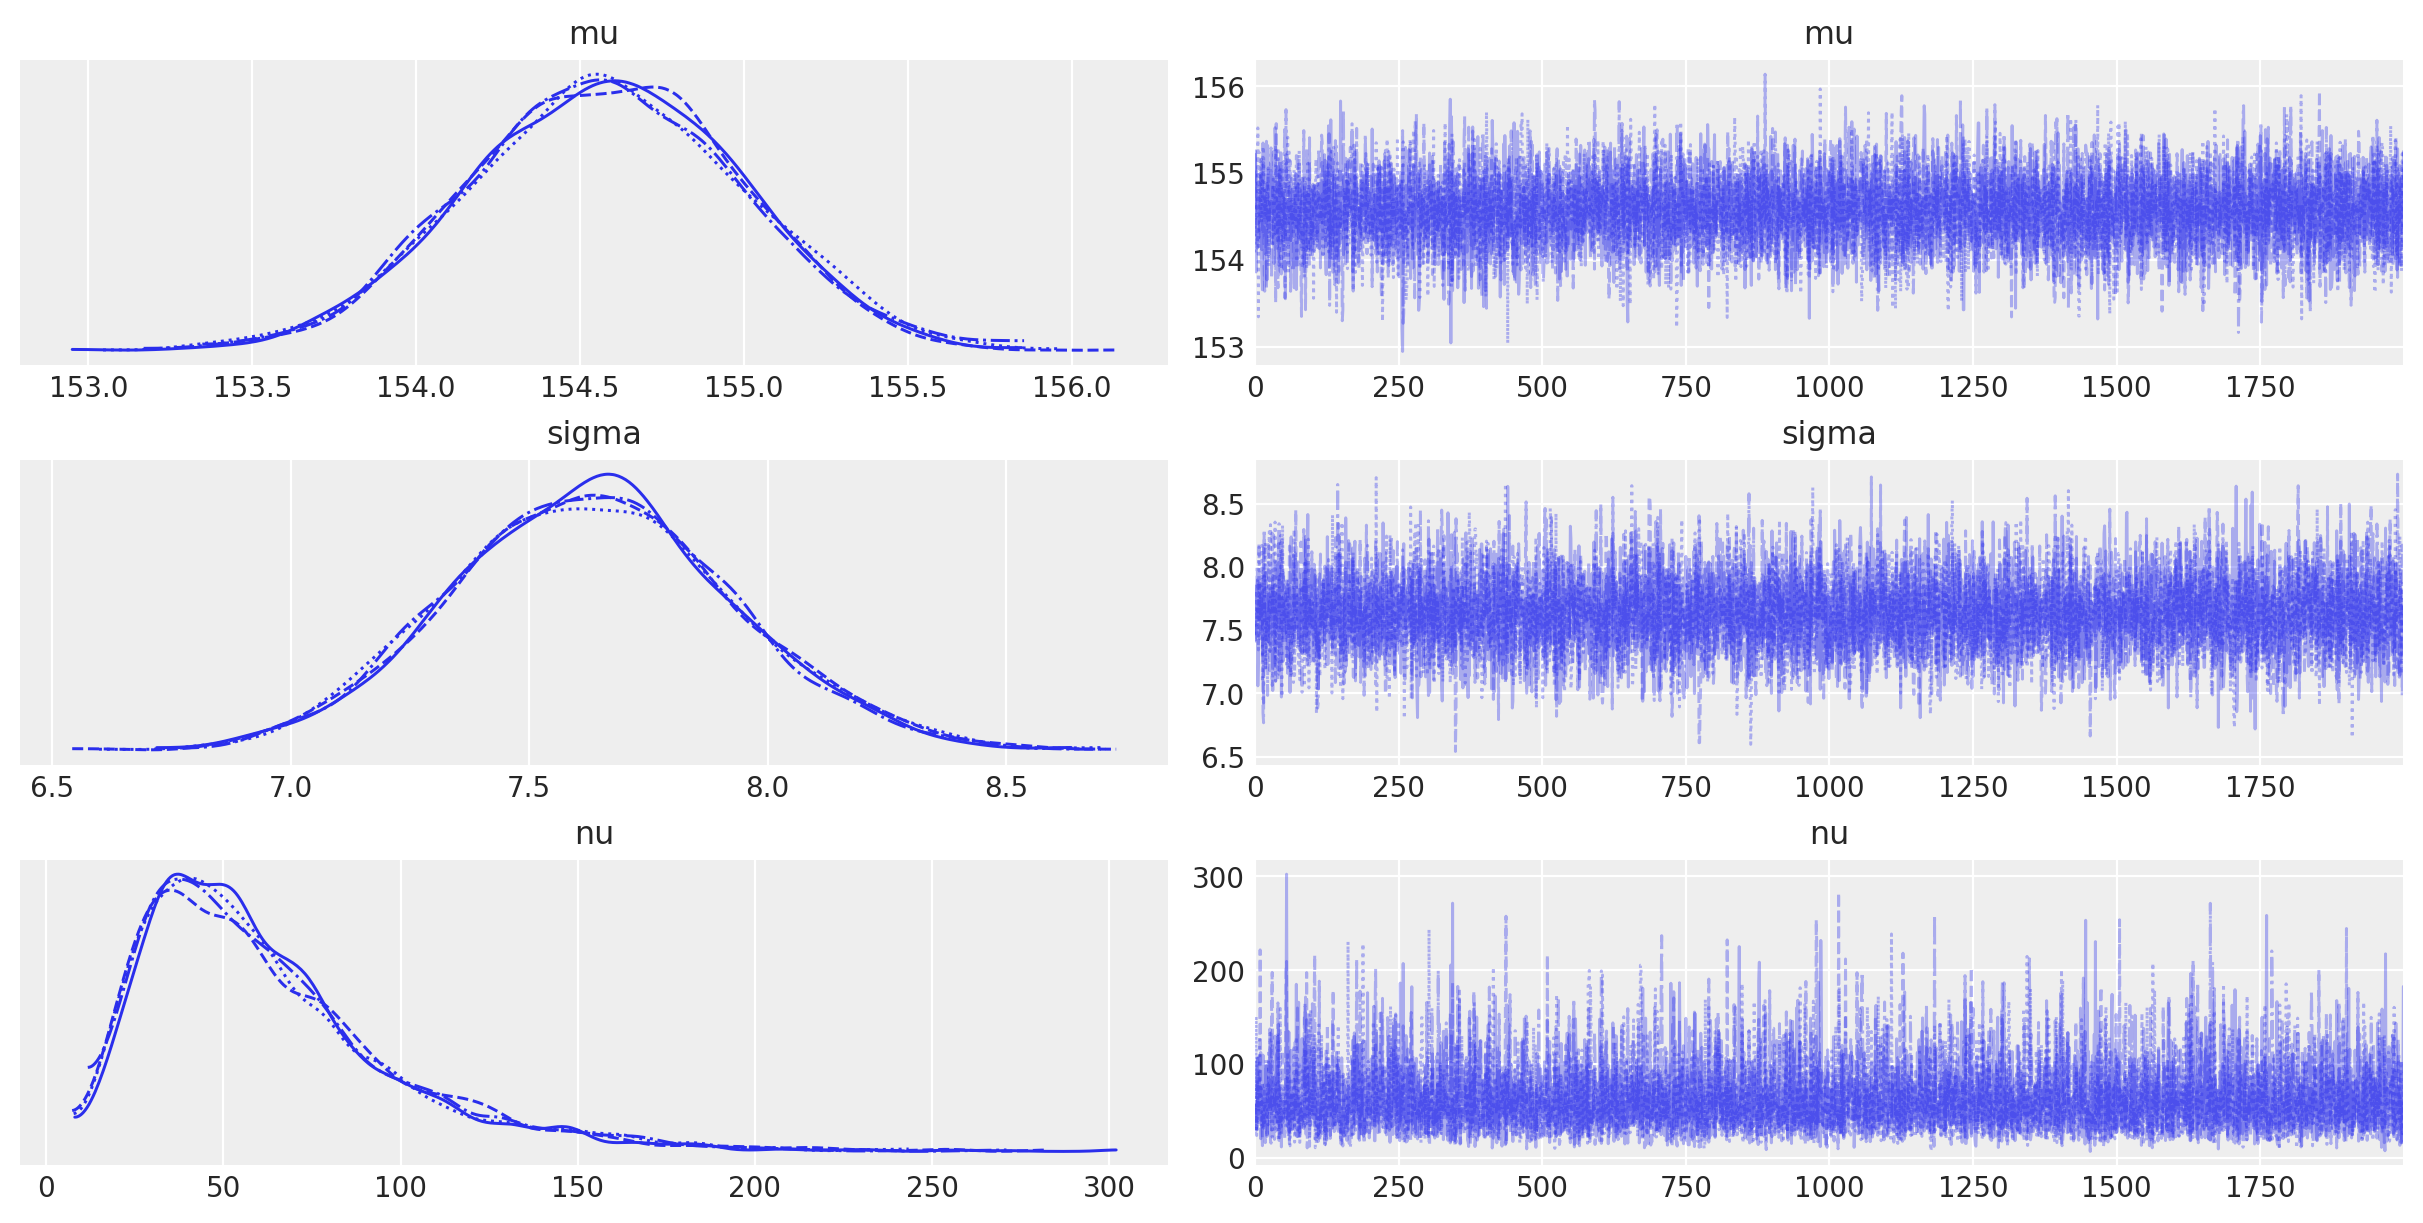

In [25]:
_ = az.plot_trace(trace_student, var_names=['mu', 'sigma', 'nu'])

In [26]:
idata = az.from_cmdstanpy(
    posterior=trace_student,
    posterior_predictive='y_rep',
    observed_data={"y": df["height"]}
)

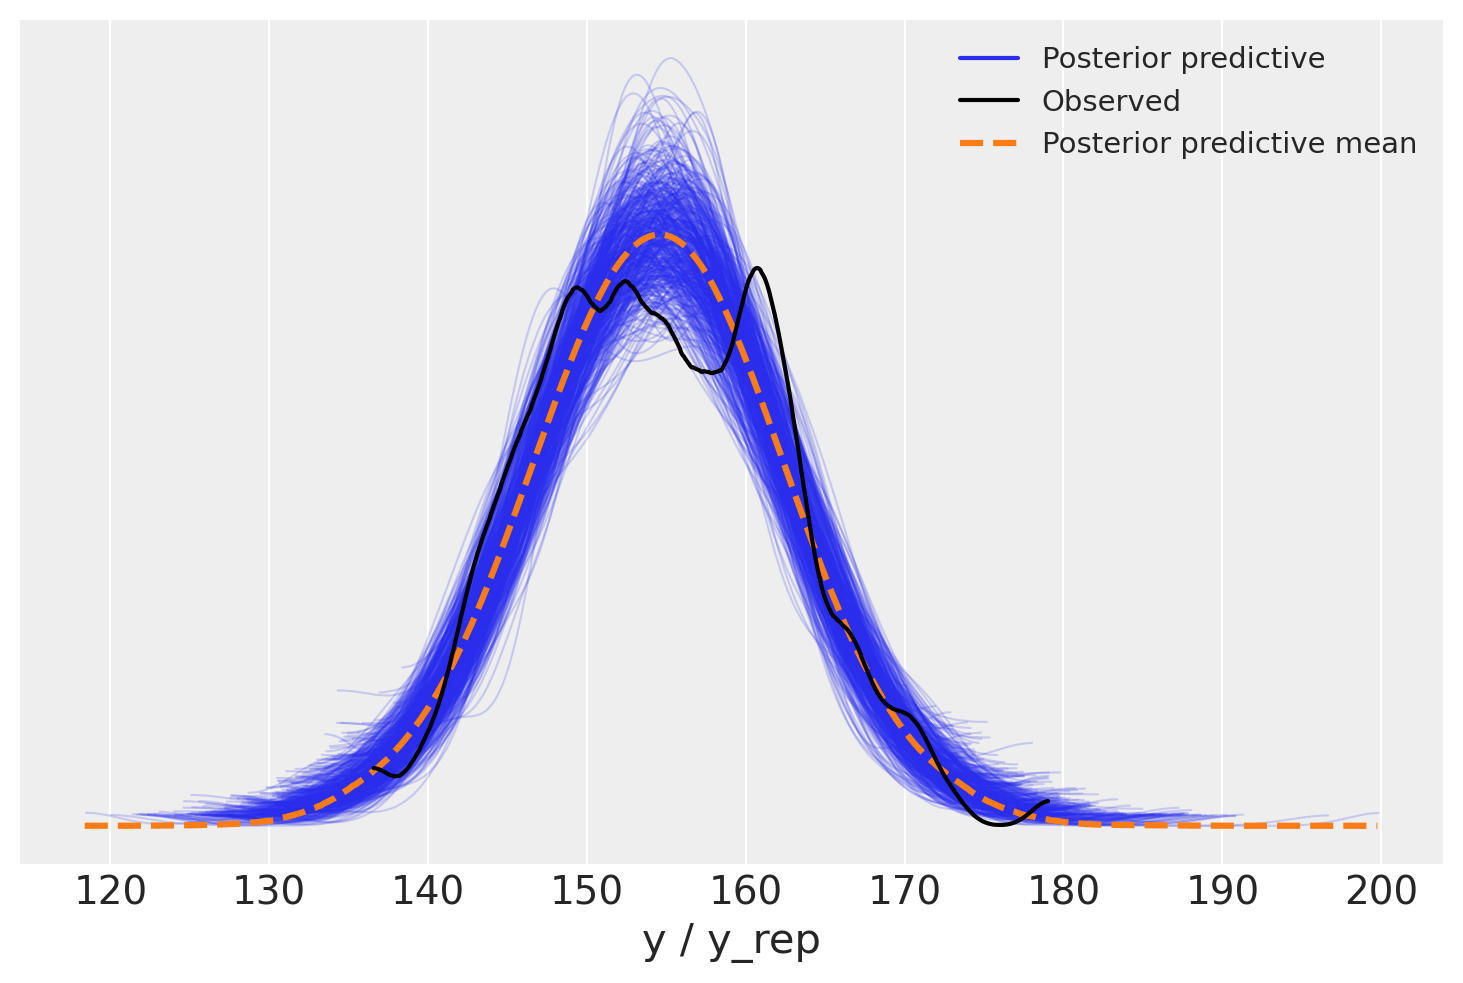

In [27]:
_ = az.plot_ppc(idata, data_pairs={"y": "y_rep"}, num_pp_samples=500)

In [28]:
az.summary(trace_student, var_names=['mu', 'sigma', 'nu'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,154.57,0.42,153.85,155.40,0.00,0.00,8798.72,6040.50,1.0
sigma,7.63,0.30,7.08,8.21,0.00,0.00,7145.94,6226.65,1.0
nu,62.39,36.10,11.40,129.62,0.41,0.31,7870.31,5565.90,1.0


In [29]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.2
pandas    : 2.2.2
arviz     : 0.18.0
numpy     : 1.26.4
cmdstanpy : 1.2.3
scipy     : 1.13.1
logging   : 0.5.1.2
matplotlib: 3.8.4

Watermark: 2.4.3

